In [1]:
# CNN does what it’s good at → images

# MLP does what it’s good at → tabular data

# Model learns complementary information

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import pandas as pd
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,accuracy_score, average_precision_score
import seaborn as sns
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import cv2
import os
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



In [2]:
df = pd.read_csv(r'Data\Dataset.csv')
df

,id,log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity,log-sigma-1-0-mm-3D_ngtdm_Coarseness,minor_axis_length,area,log-sigma-1-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_ngtdm_Coarseness,log-sigma-2-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformity,wavelet-H_ngtdm_Coarseness,...,wavelet-H_glcm_JointEntropy,wavelet-H_glrlm_GrayLevelNonUniformityNormalized,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized,log-sigma-1-0-mm-3D_glrlm_HighGrayLevelRunEmphasis,log-sigma-2-0-mm-3D_glcm_MCC,LBP_hist_bin_7,log-sigma-1-0-mm-3D_gldm_HighGrayLevelEmphasis,label,unexplained_infertility,previous_miscarriages
0,1,4809.535706,0.000247,198.625804,34583,12731.61441,0.000467,13018.03444,2687.906126,0.000138,...,3.863600,0.275603,0.205812,110.158185,0.839618,0.054680,111.058150,0,0,0
1,2,4460.623751,0.000284,193.191790,32053,11900.13194,0.000526,11521.54435,2826.917297,0.000162,...,4.119202,0.252179,0.187636,72.062320,0.853366,0.063489,72.682151,0,0,0
2,3,4925.207181,0.000240,199.327172,34346,13081.91446,0.000431,13580.04041,2784.541071,0.000135,...,3.434695,0.314459,0.231505,56.084546,0.845357,0.060094,56.346329,0,0,0
3,4,4664.352654,0.000257,195.713530,34131,12645.47833,0.000490,12945.91348,2610.770111,0.000141,...,3.599379,0.297244,0.199265,72.034173,0.868814,0.058949,72.831414,0,0,0
4,5,4420.923359,0.000271,196.147021,32842,12027.18696,0.000530,11766.90250,2474.527556,0.000152,...,3.922065,0.272541,0.179913,72.190030,0.855325,0.061050,72.673284,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,4568.094233,0.000288,219.654077,39686,14367.67661,0.000472,14273.76697,3055.538006,0.000139,...,3.333863,0.321830,0.175555,90.434190,0.869936,0.069445,90.857481,1,0,1
124,125,4664.626825,0.000275,218.066669,39662,14590.95351,0.000430,14823.92587,3175.472188,0.000136,...,3.076035,0.349690,0.193674,72.112061,0.883472,0.069538,72.611845,1,1,0
125,126,5203.038054,0.000240,229.486021,41192,14904.76695,0.000434,14441.28705,3412.583833,0.000128,...,4.018386,0.262754,0.175031,72.478047,0.846720,0.072174,72.935619,1,0,1
126,127,5362.058473,0.000235,227.372063,40050,14744.51181,0.000405,14445.17743,3592.559575,0.000131,...,4.098497,0.255446,0.195726,110.253146,0.847308,0.059026,110.723695,1,1,0


In [3]:
tabular_features = df.drop(['id', 'label', 'unexplained_infertility'], axis=1)
labels = df['label']


In [4]:
corr_matrix = tabular_features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
tabular_features_reduced = tabular_features.drop(to_drop, axis=1)
print(f"Dropped {len(to_drop)} redundant features.")

Dropped 234 redundant features.


In [5]:
selector = SelectKBest(score_func=f_classif, k=50)
x_tabular_selected = selector.fit_transform(tabular_features_reduced, labels)
selected_names = tabular_features_reduced.columns[selector.get_support()]
print("Top 10 features:", selected_names[:10].tolist())

Top 10 features: ['log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity', 'log-sigma-1-0-mm-3D_ngtdm_Coarseness', 'minor_axis_length', 'log-sigma-2-0-mm-3D_ngtdm_Coarseness', 'log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformity', 'perimeter', 'wavelet-H_gldm_DependenceNonUniformity', 'log-sigma-3-0-mm-3D_ngtdm_Coarseness', 'log-sigma-1-0-mm-3D_gldm_GrayLevelNonUniformity', 'wavelet-H_glrlm_GrayLevelNonUniformity']


In [6]:
Scaler = StandardScaler()
x_tabular_final = Scaler.fit_transform(x_tabular_selected)
y = labels.values

In [7]:
height, width = 256, 256 
batch_size=32

In [8]:
image_folder = r"C:\Users\wesal\OneDrive\Desktop\Junior-fall\Machine Learning\Uterine-Abnormality\Ultrasound-Based-Classification-of-Uterine-Abnormalities\data\images"


image_list = []

for img_id in df['id']:
    img_name = f"{int(img_id):04d}" 
    img_name += '.jpg'
    
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"Warning: image not found -> {img_path}")
        continue
    
    img = img / 255.0
    
    img = img[..., np.newaxis]
    
    image_list.append(img)

X_img = np.array(image_list, dtype=np.float32)
print("Images loaded:", X_img.shape)

Images loaded: (128, 256, 256, 1)


In [9]:
X_img_temp, X_img_test, X_tab_temp, X_tab_test, y_temp, y_test = train_test_split(
    X_img, x_tabular_final, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

X_img_train, X_img_val, X_tab_train, X_tab_val, y_train, y_val = train_test_split(
    X_img_temp, X_tab_temp, y_temp,
    test_size=0.176,   # 0.176 × 85% ≈ 15% of total
    random_state=42,
    stratify=y_temp
)


In [10]:
image_input = Input(shape=(256, 256, 1))
x = RandomFlip("horizontal")(image_input)
x = RandomRotation(0.1)(x)   
x = RandomZoom(0.1)(x)  

x = Conv2D(32, (3,3), kernel_regularizer=l2(1e-4), padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((3,3))(x)

x = Conv2D(64, (3,3), kernel_regularizer=l2(1e-4),  padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((3,3))(x)
# x = Flatten()(x)
x = Conv2D(128, (3,3), kernel_regularizer=l2(1e-4) , padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = GlobalAveragePooling2D()(x)

x = Dense(64,     kernel_regularizer=l2(1e-4), activation='relu')(x)
x = Dropout(0.3)(x)
#GAP keeps the essence of each feature map, but dramatically reduces model size.



# MLP for tabular
tab_input = Input(shape=(x_tabular_final.shape[1],))
y = Dense(128, kernel_regularizer=l2(1e-4))(tab_input)
y = BatchNormalization()(y)
y = tf.keras.layers.ReLU()(y)
y = Dropout(0.5)(y)
y = Dense(64, activation='relu')(y)

#fusion
combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(1, activation='sigmoid')(z)

model = Model(inputs=[image_input, tab_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (RandomFlip)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 256, 256,  │          0 │ random_flip[0][0] │
│ (RandomRotation)    │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom         │ (None, 256, 256,  │          0 │ random_rotation[… │
│ (RandomZoom)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ random_zoom[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 85, 85,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 85, 85,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 85, 85,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 85, 85,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      6,528 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                 

 Total params: 125,441 (490.00 KB)

 Trainable params: 124,737 (487.25 KB)

 Non-trainable params: 704 (2.75 KB)

In [11]:
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss', 
    save_best_only=True,  
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,       
    restore_best_weights=True,
    verbose=1
)


In [12]:
history = model.fit(
    [X_img_train, X_tab_train],
    y_train,
    validation_data=([X_img_val, X_tab_val], y_val),
    epochs=500,
    batch_size=4,
    callbacks=[checkpoint, early_stop]
    
)


Epoch 1/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.4901 - loss: 1.0287
Epoch 1: val_loss improved from None to 0.71226, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 236ms/step - accuracy: 0.5000 - loss: 0.9876 - val_accuracy: 0.5500 - val_loss: 0.7123
Epoch 2/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.5517 - loss: 0.8042
Epoch 2: val_loss improved from 0.71226 to 0.70495, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 303ms/step - accuracy: 0.5114 - loss: 0.8337 - val_accuracy: 0.6000 - val_loss: 0.7049
Epoch 3/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.5121 - loss: 0.8055
Epoch 3: val_loss improved from 0.70495 to 0.69936, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - accuracy: 0.5341 - loss: 0.7620 - val_accuracy: 0.6000 - val_loss: 0.6994
Epoch 4/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.4666 - loss: 0.8715
Epoch 4: val_loss improved from 0.69936 to 0.69631, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 532ms/step - accuracy: 0.5341 - loss: 0.7800 - val_accuracy: 0.5500 - val_loss: 0.6963
Epoch 5/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.4774 - loss: 0.7638
Epoch 5: val_loss improved from 0.69631 to 0.69377, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 383ms/step - accuracy: 0.5341 - loss: 0.7747 - val_accuracy: 0.7000 - val_loss: 0.6938
Epoch 6/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.5339 - loss: 0.7728
Epoch 6: val_loss improved from 0.69377 to 0.69242, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 379ms/step - accuracy: 0.5227 - loss: 0.7803 - val_accuracy: 0.6500 - val_loss: 0.6924
Epoch 7/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.4210 - loss: 0.8366
Epoch 7: val_loss improved from 0.69242 to 0.69073, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 378ms/step - accuracy: 0.4659 - loss: 0.8170 - val_accuracy: 0.6500 - val_loss: 0.6907
Epoch 8/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.4843 - loss: 0.7470
Epoch 8: val_loss improved from 0.69073 to 0.68967, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - accuracy: 0.4773 - loss: 0.7663 - val_accuracy: 0.6500 - val_loss: 0.6897
Epoch 9/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.5212 - loss: 0.7217
Epoch 9: val_loss improved from 0.68967 to 0.68815, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 344ms/step - accuracy: 0.5568 - loss: 0.7210 - val_accuracy: 0.6500 - val_loss: 0.6882
Epoch 10/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.4652 - loss: 0.8004
Epoch 10: val_loss improved from 0.68815 to 0.68555, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 397ms/step - accuracy: 0.5114 - loss: 0.7819 - val_accuracy: 0.6500 - val_loss: 0.6856
Epoch 11/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.5918 - loss: 0.7262
Epoch 11: val_loss improved from 0.68555 to 0.68479, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 357ms/step - accuracy: 0.5455 - loss: 0.7667 - val_accuracy: 0.6500 - val_loss: 0.6848
Epoch 12/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6703 - loss: 0.6849
Epoch 12: val_loss improved from 0.68479 to 0.68249, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 391ms/step - accuracy: 0.5909 - loss: 0.7364 - val_accuracy: 0.6000 - val_loss: 0.6825
Epoch 13/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.5264 - loss: 0.6934
Epoch 13: val_loss improved from 0.68249 to 0.68005, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 418ms/step - accuracy: 0.4659 - loss: 0.7417 - val_accuracy: 0.6000 - val_loss: 0.6801
Epoch 14/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.5297 - loss: 0.7501
Epoch 14: val_loss improved from 0.68005 to 0.67693, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 352ms/step - accuracy: 0.5114 - loss: 0.7740 - val_accuracy: 0.7000 - val_loss: 0.6769
Epoch 15/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.5316 - loss: 0.7750
Epoch 15: val_loss improved from 0.67693 to 0.67465, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 399ms/step - accuracy: 0.6136 - loss: 0.7421 - val_accuracy: 0.7000 - val_loss: 0.6746
Epoch 16/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.5790 - loss: 0.7270
Epoch 16: val_loss improved from 0.67465 to 0.67140, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 353ms/step - accuracy: 0.5568 - loss: 0.7465 - val_accuracy: 0.7000 - val_loss: 0.6714
Epoch 17/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.6206 - loss: 0.6836
Epoch 17: val_loss improved from 0.67140 to 0.67020, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 364ms/step - accuracy: 0.5909 - loss: 0.6936 - val_accuracy: 0.7000 - val_loss: 0.6702
Epoch 18/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.5377 - loss: 0.8058
Epoch 18: val_loss improved from 0.67020 to 0.66697, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - accuracy: 0.5909 - loss: 0.7400 - val_accuracy: 0.7000 - val_loss: 0.6670
Epoch 19/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.5763 - loss: 0.6943
Epoch 19: val_loss improved from 0.66697 to 0.66460, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 365ms/step - accuracy: 0.5568 - loss: 0.7238 - val_accuracy: 0.7000 - val_loss: 0.6646
Epoch 20/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.5850 - loss: 0.6665
Epoch 20: val_loss improved from 0.66460 to 0.65999, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 373ms/step - accuracy: 0.5795 - loss: 0.6907 - val_accuracy: 0.7000 - val_loss: 0.6600
Epoch 21/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.6586 - loss: 0.6752
Epoch 21: val_loss improved from 0.65999 to 0.65454, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 436ms/step - accuracy: 0.6250 - loss: 0.7063 - val_accuracy: 0.7000 - val_loss: 0.6545
Epoch 22/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6107 - loss: 0.6787
Epoch 22: val_loss improved from 0.65454 to 0.65008, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 362ms/step - accuracy: 0.5795 - loss: 0.7198 - val_accuracy: 0.7000 - val_loss: 0.6501
Epoch 23/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.5122 - loss: 0.7454
Epoch 23: val_loss improved from 0.65008 to 0.64238, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step - accuracy: 0.5795 - loss: 0.7156 - val_accuracy: 0.7000 - val_loss: 0.6424
Epoch 24/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.5747 - loss: 0.6970
Epoch 24: val_loss improved from 0.64238 to 0.63946, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.5682 - loss: 0.7129 - val_accuracy: 0.7000 - val_loss: 0.6395
Epoch 25/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.5178 - loss: 0.7597
Epoch 25: val_loss did not improve from 0.63946
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 390ms/step - accuracy: 0.6023 - loss: 0.7014 - val_accuracy: 0.7000 - val_loss: 0.6395
Epoch 26/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.4717 - loss: 0.7513
Epoch 26: val_loss improved from 0.63946 to 0.63673, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 380ms/step - accuracy: 0.5000 - loss: 0.7512 - val_accuracy: 0.7000 - val_loss: 0.6367
Epoch 27/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6466 - loss: 0.6880
Epoch 27: val_loss improved from 0.63673 to 0.63452, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 392ms/step - accuracy: 0.6250 - loss: 0.7041 - val_accuracy: 0.7000 - val_loss: 0.6345
Epoch 28/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.5913 - loss: 0.7200
Epoch 28: val_loss did not improve from 0.63452
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 379ms/step - accuracy: 0.6023 - loss: 0.7086 - val_accuracy: 0.7000 - val_loss: 0.6351
Epoch 29/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.5642 - loss: 0.7140
Epoch 29: val_loss did not improve from 0.63452
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 371ms/step - accuracy: 0.5795 - loss: 0.7260 - val_accuracy: 0.7000 - val_loss: 0.6367
Epoch 30/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.5985 - loss: 0.6558
Epoch 30: val_loss improved from 0.63452 to 0.63347, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 384ms/step - accuracy: 0.5795 - loss: 0.6749 - val_accuracy: 0.7000 - val_loss: 0.6335
Epoch 31/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6968 - loss: 0.6541
Epoch 31: val_loss improved from 0.63347 to 0.63222, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 381ms/step - accuracy: 0.6136 - loss: 0.6952 - val_accuracy: 0.7000 - val_loss: 0.6322
Epoch 32/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.4998 - loss: 0.7297
Epoch 32: val_loss did not improve from 0.63222
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 351ms/step - accuracy: 0.5114 - loss: 0.7409 - val_accuracy: 0.6000 - val_loss: 0.6561
Epoch 33/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6377 - loss: 0.6604
Epoch 33: val_loss did not improve from 0.63222
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 383ms/step - accuracy: 0.6364 - loss: 0.6487 - val_accuracy: 0.6500 - val_loss: 0.6356
Epoch 34/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.5792 - loss: 0.6955
Epoch 34: val_loss did not improve from 0.63222
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step - accuracy: 0.6250 - loss: 0.6981 - val_accuracy: 0.6500 - val_loss: 0.6384
Epoch 35/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.6267 - loss: 0.6481
Epoch 35: val_loss did not improve

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 382ms/step - accuracy: 0.6023 - loss: 0.7052 - val_accuracy: 0.6000 - val_loss: 0.6197
Epoch 40/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.5669 - loss: 0.7071
Epoch 40: val_loss did not improve from 0.61965
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 350ms/step - accuracy: 0.5455 - loss: 0.7248 - val_accuracy: 0.6000 - val_loss: 0.6228
Epoch 41/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6755 - loss: 0.6558
Epoch 41: val_loss did not improve from 0.61965
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 378ms/step - accuracy: 0.6364 - loss: 0.6916 - val_accuracy: 0.6000 - val_loss: 0.6221
Epoch 42/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.5623 - loss: 0.7020
Epoch 42: val_loss improved from 0.61965 to 0.61491, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 379ms/step - accuracy: 0.5455 - loss: 0.6986 - val_accuracy: 0.6000 - val_loss: 0.6149
Epoch 43/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.5580 - loss: 0.7100
Epoch 43: val_loss did not improve from 0.61491
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 381ms/step - accuracy: 0.5568 - loss: 0.7119 - val_accuracy: 0.6500 - val_loss: 0.6187
Epoch 44/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.6177 - loss: 0.6911
Epoch 44: val_loss did not improve from 0.61491
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 348ms/step - accuracy: 0.6818 - loss: 0.6556 - val_accuracy: 0.6500 - val_loss: 0.6153
Epoch 45/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.5552 - loss: 0.6556
Epoch 45: val_loss improved from 0.61491 to 0.61248, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 370ms/step - accuracy: 0.5795 - loss: 0.6855 - val_accuracy: 0.6500 - val_loss: 0.6125
Epoch 46/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.6306 - loss: 0.6887
Epoch 46: val_loss improved from 0.61248 to 0.61039, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - accuracy: 0.6364 - loss: 0.6878 - val_accuracy: 0.6500 - val_loss: 0.6104
Epoch 47/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.6271 - loss: 0.6777
Epoch 47: val_loss did not improve from 0.61039
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6364 - loss: 0.6524 - val_accuracy: 0.6500 - val_loss: 0.6207
Epoch 48/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.5865 - loss: 0.7239
Epoch 48: val_loss did not improve from 0.61039
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 347ms/step - accuracy: 0.5909 - loss: 0.6995 - val_accuracy: 0.6500 - val_loss: 0.6131
Epoch 49/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.7348 - loss: 0.6244
Epoch 49: val_loss did not improve from 0.61039
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 353ms/step - accuracy: 0.6364 - loss: 0.6483 - val_accuracy: 0.6000 - val_loss: 0.6167
Epoch 50/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.6524 - loss: 0.6593
Epoch 50: val_loss did not improve 

22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 407ms/step - accuracy: 0.7273 - loss: 0.6184 - val_accuracy: 0.6500 - val_loss: 0.5981
Epoch 56/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.5818 - loss: 0.6814
Epoch 56: val_loss improved from 0.59807 to 0.59592, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 384ms/step - accuracy: 0.5568 - loss: 0.6692 - val_accuracy: 0.7500 - val_loss: 0.5959
Epoch 57/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.6649 - loss: 0.7201
Epoch 57: val_loss improved from 0.59592 to 0.59484, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 362ms/step - accuracy: 0.6136 - loss: 0.7132 - val_accuracy: 0.7500 - val_loss: 0.5948
Epoch 58/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.5962 - loss: 0.6531
Epoch 58: val_loss did not improve from 0.59484
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 359ms/step - accuracy: 0.6591 - loss: 0.6314 - val_accuracy: 0.7000 - val_loss: 0.5951
Epoch 59/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.6226 - loss: 0.6990
Epoch 59: val_loss did not improve from 0.59484
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step - accuracy: 0.5455 - loss: 0.7023 - val_accuracy: 0.6500 - val_loss: 0.6017
Epoch 60/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.6445 - loss: 0.6655
Epoch 60: val_loss did not improve from 0.59484
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 392ms/step - accuracy: 0.6477 - loss: 0.6225 - val_accuracy: 0.6500 - val_loss: 0.6011
Epoch 61/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.5752 - loss: 0.7164
Epoch 61: val_loss did not improve 


==================== VALIDATION REPORT ====================
Accuracy:  0.7500
ROC AUC:   0.8687
PR AUC:    0.8226

Classification Report:
              precision    recall  f1-score   support

      Normal       0.75      0.82      0.78        11
    Abnormal       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20


==================== TEST REPORT ====================
Accuracy:  0.6000
ROC AUC:   0.7071
PR AUC:    0.7212

Classification Report:
              precision    recall  f1-score   support

      Normal       0.67      0.55      0.60        11
    Abnormal       0.55      0.67      0.60         9

    accuracy                           0.60        20
   macro avg       0.61      0.61      0.60        20
weighted avg       0.61      0.60      0.60        20



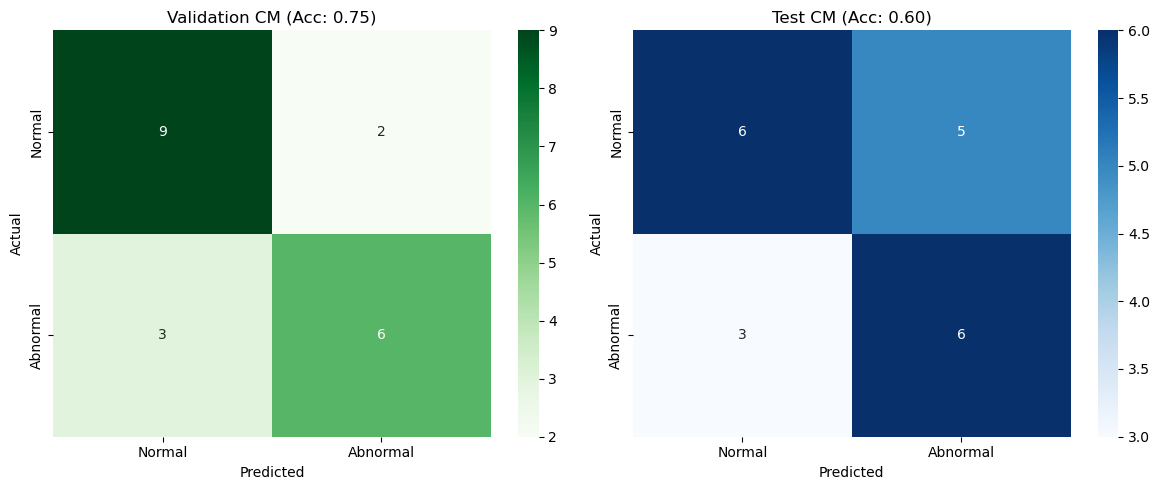

In [13]:
def evaluate_set(images, tabular, labels, set_name):
    probs = model.predict([images, tabular], verbose=0).ravel()
    preds = (probs > 0.5).astype(int)
    
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, probs)
    ap = average_precision_score(labels, probs)
    
    print(f"\n{'='*20} {set_name.upper()} REPORT {'='*20}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"ROC AUC:   {auc:.4f}")
    print(f"PR AUC:    {ap:.4f}")
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=['Normal', 'Abnormal']))
    
    return confusion_matrix(labels, preds), acc

cm_val, acc_val = evaluate_set(X_img_val, X_tab_val, y_val, "Validation")
cm_test, acc_test = evaluate_set(X_img_test, X_tab_test, y_test, "Test")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens', ax=ax[0],
            xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
ax[0].set_title(f'Validation CM (Acc: {acc_val:.2f})')
ax[0].set_ylabel('Actual')
ax[0].set_xlabel('Predicted')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax[1],
            xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
ax[1].set_title(f'Test CM (Acc: {acc_test:.2f})')
ax[1].set_ylabel('Actual')
ax[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()


In [14]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model.h5')


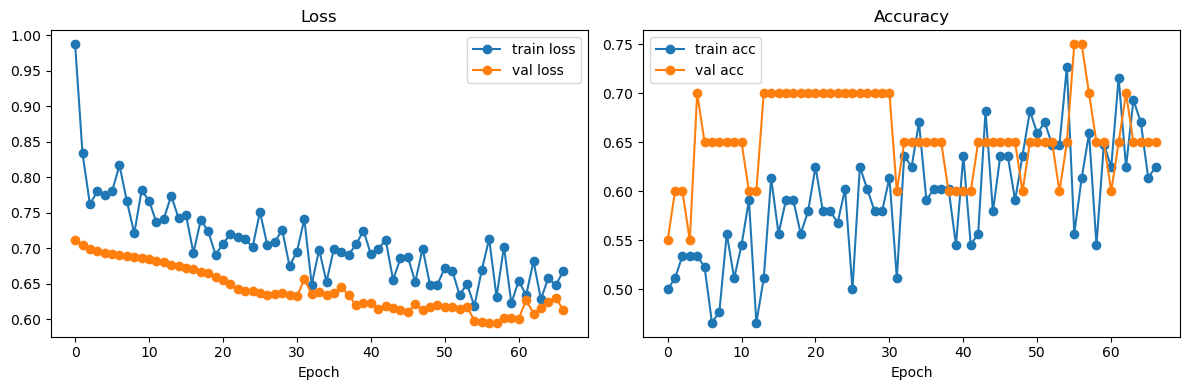

In [15]:
history_dict = history.history
loss = history_dict.get('loss')
val_loss = history_dict.get('val_loss')
acc = history_dict.get('accuracy', history_dict.get('acc'))
val_acc = history_dict.get('val_accuracy', history_dict.get('val_acc'))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(loss, 'o-', label='train loss')
plt.plot(val_loss, 'o-', label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
if acc is not None and val_acc is not None:
    plt.plot(acc, 'o-', label='train acc')
    plt.plot(val_acc, 'o-', label='val acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No accuracy data in history', ha='center', va='center')

plt.tight_layout()
plt.show()